## Accessing USDA NASS Cropland Data Layers (CDLs) with the Planetary Computer STAC API

The [USDA NASS Cropland Data Layers (CDLs)](https://www.nass.usda.gov/Research_and_Science/Cropland/SARS1a.php) include Cropland, Confidence, Cultivated, and Frequency products. The Cropland product is a crop-specific land cover data layer created annually for the contiguous United States (CONUS). A corresponding Confidence product represents the predicted confidence that is associated with an output pixel. A value of zero indicates low confidence, while a value of 100 indicates high confidence. The Cultivated product identifies cultivated and non-cultivated land cover for CONUS and is based on land cover information derived from the 2017 through 2021 Cropland products. The Frequency product identifies crop specific planting frequency and are based on land cover information derived from the 2008 through 2021 Cropland products. There are currently four individual crop frequency data layers that represent four major crops: corn, cotton, soybeans, and wheat. All products have a 30 meter resolution.

Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/usda-cdl).

### Data Access
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [1]:
import planetary_computer
import pystac_client

# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("usda-cdl")
collection

ID: usda-cdl
Title: USDA Cropland Data Layers (CDLs)
"Description: The USDA NASS Cropland Data Layers (CDLs) include Cropland, Confidence, Cultivated, and Frequency products. The Cropland product is a crop-specific land cover data layer created annually for the contiguous United States (CONUS). A corresponding Confidence product represents the predicted confidence that is associated with an output pixel. A value of zero indicates low confidence, while a value of 100 indicates high confidence. The Cultivated product identifies cultivated and non-cultivated land cover for CONUS and is based on land cover information derived from the 2017 through 2021 Cropland products. The Frequency product identifies crop specific planting frequency and are based on land cover information derived from the 2008 through 2021 Cropland products. There are currently four individual crop frequency data layers that represent four major crops: corn, cotton, soybeans, and wheat. All products have a 30 meter resolution."
"Providers: United States Department of Agriculture - National Agricultural Statistics Service (producer, licensor) Microsoft (host)"
type: Collection
title: USDA Cropland Data Layers (CDLs)
"assets: {'thumbnail': {'href': 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/usda-cdl-thumb.png', 'type': 'image/png', 'roles': ['thumbnail'], 'title': 'USDA Cropland Data Layer (CDL) thumbnail'}}"
"keywords: ['USDA', 'United States', 'Land Cover', 'Land Use', 'Agriculture']"
"providers: [{'url': 'https://www.nass.usda.gov/', 'name': 'United States Department of Agriculture - National Agricultural Statistics Service', 'roles': ['producer', 'licensor']}, {'url': 'https://planetarycomputer.microsoft.com', 'name': 'Microsoft', 'roles': ['host']}]"
msft:container: usda-cdl
"stac_extensions: ['https://stac-extensions.github.io/item-assets/v1.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json', 'https://stac-extensions.github.io/classification/v1.1.0/schema.json']"


In [2]:
# Search the catalog and collection for desired items
latitude = 36.7378
longitude = -119.7871

Fresno = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": Fresno,
}

search = catalog.search(
    collections=collection,
    intersects=geometry,
    datetime="2021",
)
items = list(search.get_items())
items

[<Item id=cultivated_2021_-2086095_1822575_90000>,
 <Item id=cropland_2021_-2086095_1822575_90000>,
 <Item id=frequency_2008-2021_-2086095_1822575_90000>]

### Available Assets & Metadata

Let's display the available [assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) and metadata.

In [3]:
import rich.table

# Assets
t_assets = rich.table.Table("Key", "Value")
for key, asset in items[1].assets.items():
    t_assets.add_row(key, asset.title)
t_assets

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Value                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cropland         │ Cropland Data Layer (CDL) 2021  │
│ confidence       │ Confidence 2021                 │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [4]:
# Metadata
t_metadata = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t_metadata.add_row(k, str(v))
t_metadata

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key            ┃ Value                                          ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ datetime       │ None                                           │
│ end_datetime   │ 2021-12-31T23:59:59Z                           │
│ proj:epsg      │ 5070                                           │
│ proj:shape     │ [3000, 3000]                                   │
│ proj:transform │ [30.0, 0.0, -2086095.0, 0.0, -30.0, 1822605.0] │
│ start_datetime │ 2021-01-01T00:00:00Z                           │
│ usda_cdl:type  │ cultivated                                     │
└────────────────┴────────────────────────────────────────────────┘

### Loading the data
Now let's load STAC items into an xarray dataset using [odc-stac](https://github.com/opendatacube/odc-stac).

In [5]:
import odc.stac

ds = odc.stac.load(items)
ds

<xarray.Dataset>
Dimensions:      (y: 3001, x: 3001, time: 2)
Coordinates:
  * y            (y) float64 1.823e+06 1.823e+06 ... 1.733e+06 1.733e+06
  * x            (x) float64 -2.086e+06 -2.086e+06 ... -1.996e+06 -1.996e+06
    spatial_ref  int32 5070
  * time         (time) datetime64[ns] 2008-01-01 2021-01-01
Data variables:
    cultivated   (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    cropland     (time, y, x) uint8 0 0 0 0 0 0 0 ... 142 142 142 142 142 142
    confidence   (time, y, x) uint8 0 0 0 0 0 0 0 ... 100 100 100 100 100 100
    corn         (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    cotton       (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    wheat        (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    soybeans     (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255

### Displaying the data

This dataset includes a preferred colormap mapping raster values to colors. The Collection's `item_assets` field includes an overview of the class descriptions and values.

In [6]:
from pystac.extensions.item_assets import ItemAssetsExtension

ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["cropland"]

class_names = {
    x["description"]: x["value"] for x in x.properties["classification:classes"]
}
class_values = {v: k for k, v in class_names.items()}

t = rich.table.Table("Description", "Value")
for k, v in class_names.items():
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Description              ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Corn                     │ 1     │
│ Cotton                   │ 2     │
│ Rice                     │ 3     │
│ Sorghum                  │ 4     │
│ Soybeans                 │ 5     │
│ Sunflower                │ 6     │
│ Peanuts                  │ 10    │
│ Tobacco                  │ 11    │
│ Sweet Corn               │ 12    │
│ Pop or Orn Corn          │ 13    │
│ Mint                     │ 14    │
│ Barley                   │ 21    │
│ Durum Wheat              │ 22    │
│ Spring Wheat             │ 23    │
│ Winter Wheat             │ 24    │
│ Other Small Grains       │ 25    │
│ Winter Wheat/Soybeans    │ 26    │
│ Rye                      │ 27    │
│ Oats                     │ 28    │
│ Millet                   │ 29    │
│ Speltz                   │ 30    │
│ Canola                   │ 31    │
│ Flaxseed                 │ 32    │
│ Safflower                │ 33    │
│ Rape Seed                │ 34    │
│ Mustard                  │ 35    │
│ Alfalfa                  │ 36    │
│ Other Hay/Non Alfalfa    │ 37    │
│ Camelina                 │ 38    │
│ Buckwheat                │ 39    │
│ Sugarbeets               │ 41    │
│ Dry Beans                │ 42    │
│ Potatoes                 │ 43    │
│ Other Crops              │ 44    │
│ Sugarcane                │ 45    │
│ Sweet Potatoes           │ 46    │
│ Misc. Vegs & Fruits      │ 47    │
│ Watermelons              │ 48    │
│ Onions                   │ 49    │
│ Cucumbers                │ 50    │
│ Chick Peas               │ 51    │
│ Lentils                  │ 52    │
│ Peas                     │ 53    │
│ Tomatoes                 │ 54    │
│ Caneberries              │ 55    │
│ Hops                     │ 56    │
│ Herbs                    │ 57    │
│ Clover/Wildflowers       │ 58    │
│ Sod/Grass Seed           │ 59    │
│ Switchgrass              │ 60    │
│ Fallow/Idle Cropland     │ 61    │
│ Forest                   │ 63    │
│ Shrubland                │ 152   │
│ Barren                   │ 131   │
│ Cherries                 │ 66    │
│ Peaches                  │ 67    │
│ Apples                   │ 68    │
│ Grapes                   │ 69    │
│ Christmas Trees          │ 70    │
│ Other Tree Crops         │ 71    │
│ Citrus                   │ 72    │
│ Pecans                   │ 74    │
│ Almonds                  │ 75    │
│ Walnuts                  │ 76    │
│ Pears                    │ 77    │
│ Clouds/No Data           │ 81    │
│ Developed                │ 82    │
│ Water                    │ 83    │
│ Wetlands                 │ 87    │
│ Nonag/Undefined          │ 88    │
│ Aquaculture              │ 92    │
│ Open Water               │ 111   │
│ Perennial Ice/Snow       │ 112   │
│ Developed/Open Space     │ 121   │
│ Developed/Low Intensity  │ 122   │
│ Developed/Med Intensity  │ 123   │
│ Developed/High Intensity │ 124   │
│ Deciduous Forest         │ 141   │
│ Evergreen Forest         │ 142   │
│ Mixed Forest             │ 143   │
│ Grassland/Pasture        │ 176   │
│ Woody Wetlands           │ 190   │
│ Herbaceous Wetlands      │ 195   │
│ Pistachios               │ 204   │
│ Triticale                │ 205   │
│ Carrots                  │ 206   │
│ Asparagus                │ 207   │
│ Garlic                   │ 208   │
│ Cantaloupes              │ 209   │
│ Prunes                   │ 210   │
│ Olives                   │ 211   │
│ Oranges                  │ 212   │
│ Honeydew Melons          │ 213   │
│ Broccoli                 │ 214   │
│ Avocados                 │ 215   │
│ Peppers                  │ 216   │
│ Pomegranates             │ 217   │
│ Nectarines               │ 218   │
│ Greens                   │ 219   │
│ Plums                    │ 220   │
│ Strawberreis             │ 221   │
│ Squash                   │ 222   │
│ Apricots                 │ 223   │
│ Vetch                    │ 224   │
│ Winter Wheat/Corn        │ 225   │
│ Oa

And the Planetary Computer's [Data API](https://planetarycomputer.microsoft.com/api/data/v1/docs) includes the colormap.

In [13]:
import requests

classmap = requests.get(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/data/legend/classmap/usda-cdl"
).json()
classmap

In [14]:
classmap = {
    0: (0, 0, 0, 0),
    1: (255, 212, 0, 255),
    2: (255, 38, 38, 255),
    3: (0, 169, 230, 255),
    4: (255, 158, 15, 255),
    5: (38, 115, 0, 255),
    6: (255, 255, 0, 255),
    7: (0, 0, 0, 0),  # should we remove all 0,0,0,0?
    8: (0, 0, 0, 0),
    9: (0, 0, 0, 0),
    10: (112, 168, 0, 255),
    11: (0, 175, 77, 255),
    12: (224, 166, 15, 255),
    13: (224, 166, 15, 255),
    14: (128, 212, 255, 255),
    15: (0, 0, 0, 0),
    16: (0, 0, 0, 0),
    17: (0, 0, 0, 0),
    18: (0, 0, 0, 0),
    19: (0, 0, 0, 0),
    20: (0, 0, 0, 0),
    21: (226, 0, 127, 255),
    22: (138, 100, 83, 255),
    23: (217, 181, 108, 255),
    24: (168, 112, 0, 255),
    25: (214, 157, 188, 255),
    26: (115, 115, 0, 255),
    27: (174, 1, 126, 255),
    28: (161, 88, 137, 255),
    29: (115, 0, 76, 255),
    30: (214, 157, 188, 255),
    31: (209, 255, 0, 255),
    32: (128, 153, 255, 255),
    33: (214, 214, 0, 255),
    34: (209, 255, 0, 255),
    35: (0, 175, 77, 255),
    36: (255, 168, 227, 255),
    37: (165, 245, 141, 255),
    38: (0, 175, 77, 255),
    39: (214, 157, 188, 255),
    40: (0, 0, 0, 0),
    41: (169, 0, 230, 255),
    42: (168, 0, 0, 255),
    43: (115, 38, 0, 255),
    44: (0, 175, 77, 255),
    45: (179, 128, 255, 255),
    46: (115, 38, 0, 255),
    47: (255, 102, 102, 255),
    48: (255, 102, 102, 255),
    49: (255, 204, 102, 255),
    50: (255, 102, 102, 255),
    51: (0, 175, 77, 255),
    52: (0, 222, 176, 255),
    53: (85, 255, 0, 255),
    54: (245, 162, 122, 255),
    55: (255, 102, 102, 255),
    56: (0, 175, 77, 255),
    57: (128, 212, 255, 255),
    58: (232, 190, 255, 255),
    59: (178, 255, 222, 255),
    60: (0, 175, 77, 255),
    61: (191, 191, 122, 255),
    62: (0, 0, 0, 0),
    63: (149, 206, 147, 255),
    64: (199, 215, 158, 255),
    65: (204, 191, 163, 255),
    66: (255, 0, 255, 255),
    67: (255, 145, 171, 255),
    68: (185, 0, 80, 255),
    69: (112, 68, 137, 255),
    70: (0, 120, 120, 255),
    71: (179, 156, 112, 255),
    72: (255, 255, 128, 255),
    73: (0, 0, 0, 0),
    74: (182, 112, 92, 255),
    75: (0, 168, 132, 255),
    76: (235, 214, 176, 255),
    77: (179, 156, 112, 255),
    78: (0, 0, 0, 0),
    79: (0, 0, 0, 0),
    80: (0, 0, 0, 0),
    81: (247, 247, 247, 255),
    82: (156, 156, 156, 255),
    83: (77, 112, 163, 255),
    84: (0, 0, 0, 0),
    85: (0, 0, 0, 0),
    86: (0, 0, 0, 0),
    87: (128, 179, 179, 255),
    88: (233, 255, 190, 255),
    89: (0, 0, 0, 0),
    90: (0, 0, 0, 0),
    91: (0, 0, 0, 0),
    92: (0, 255, 255, 255),
    93: (0, 0, 0, 0),
    94: (0, 0, 0, 0),
    95: (0, 0, 0, 0),
    96: (0, 0, 0, 0),
    97: (0, 0, 0, 0),
    98: (0, 0, 0, 0),
    99: (0, 0, 0, 0),
    100: (0, 0, 0, 0),
    101: (0, 0, 0, 0),
    102: (0, 0, 0, 0),
    103: (0, 0, 0, 0),
    104: (0, 0, 0, 0),
    105: (0, 0, 0, 0),
    106: (0, 0, 0, 0),
    107: (0, 0, 0, 0),
    108: (0, 0, 0, 0),
    109: (0, 0, 0, 0),
    110: (0, 0, 0, 0),
    111: (77, 112, 163, 255),
    112: (212, 227, 252, 255),
    113: (0, 0, 0, 0),
    114: (0, 0, 0, 0),
    115: (0, 0, 0, 0),
    116: (0, 0, 0, 0),
    117: (0, 0, 0, 0),
    118: (0, 0, 0, 0),
    119: (0, 0, 0, 0),
    120: (0, 0, 0, 0),
    121: (156, 156, 156, 255),
    122: (156, 156, 156, 255),
    123: (156, 156, 156, 255),
    124: (156, 156, 156, 255),
    125: (0, 0, 0, 0),
    126: (0, 0, 0, 0),
    127: (0, 0, 0, 0),
    128: (0, 0, 0, 0),
    129: (0, 0, 0, 0),
    130: (0, 0, 0, 0),
    131: (204, 191, 163, 255),
    132: (0, 0, 0, 0),
    133: (0, 0, 0, 0),
    134: (0, 0, 0, 0),
    135: (0, 0, 0, 0),
    136: (0, 0, 0, 0),
    137: (0, 0, 0, 0),
    138: (0, 0, 0, 0),
    139: (0, 0, 0, 0),
    140: (0, 0, 0, 0),
    141: (149, 206, 147, 255),
    142: (149, 206, 147, 255),
    143: (149, 206, 147, 255),
    144: (0, 0, 0, 0),
    145: (0, 0, 0, 0),
    146: (0, 0, 0, 0),
    147: (0, 0, 0, 0),
    148: (0, 0, 0, 0),
    149: (0, 0, 0, 0),
    150: (0, 0, 0, 0),
    151: (0, 0, 0, 0),
    152: (199, 215, 158, 255),
    153: (0, 0, 0, 0),
    154: (0, 0, 0, 0),
    155: (0, 0, 0, 0),
    156: (0, 0, 0, 0),
    157: (0, 0, 0, 0),
    158: (0, 0, 0, 0),
    159: (0, 0, 0, 0),
    160: (0, 0, 0, 0),
    161: (0, 0, 0, 0),
    162: (0, 0, 0, 0),
    163: (0, 0, 0, 0),
    164: (0, 0, 0, 0),
    165: (0, 0, 0, 0),
    166: (0, 0, 0, 0),
    167: (0, 0, 0, 0),
    168: (0, 0, 0, 0),
    169: (0, 0, 0, 0),
    170: (0, 0, 0, 0),
    171: (0, 0, 0, 0),
    172: (0, 0, 0, 0),
    173: (0, 0, 0, 0),
    174: (0, 0, 0, 0),
    175: (0, 0, 0, 0),
    176: (233, 255, 190, 255),
    177: (0, 0, 0, 0),
    178: (0, 0, 0, 0),
    179: (0, 0, 0, 0),
    180: (0, 0, 0, 0),
    181: (0, 0, 0, 0),
    182: (0, 0, 0, 0),
    183: (0, 0, 0, 0),
    184: (0, 0, 0, 0),
    185: (0, 0, 0, 0),
    186: (0, 0, 0, 0),
    187: (0, 0, 0, 0),
    188: (0, 0, 0, 0),
    189: (0, 0, 0, 0),
    190: (128, 179, 179, 255),
    191: (0, 0, 0, 0),
    192: (0, 0, 0, 0),
    193: (0, 0, 0, 0),
    194: (0, 0, 0, 0),
    195: (128, 179, 179, 255),
    196: (0, 0, 0, 0),
    197: (0, 0, 0, 0),
    198: (0, 0, 0, 0),
    199: (0, 0, 0, 0),
    200: (0, 0, 0, 0),
    201: (0, 0, 0, 0),
    202: (0, 0, 0, 0),
    203: (0, 0, 0, 0),
    204: (0, 255, 140, 255),
    205: (214, 157, 188, 255),
    206: (255, 102, 102, 255),
    207: (255, 102, 102, 255),
    208: (255, 102, 102, 255),
    209: (255, 102, 102, 255),
    210: (255, 145, 171, 255),
    211: (52, 74, 52, 255),
    212: (230, 117, 37, 255),
    213: (255, 102, 102, 255),
    214: (255, 102, 102, 255),
    215: (102, 153, 77, 255),
    216: (255, 102, 102, 255),
    217: (179, 156, 112, 255),
    218: (255, 145, 171, 255),
    219: (255, 102, 102, 255),
    220: (255, 145, 171, 255),
    221: (255, 102, 102, 255),
    222: (255, 102, 102, 255),
    223: (255, 145, 171, 255),
    224: (0, 175, 77, 255),
    225: (255, 212, 0, 255),
    226: (255, 212, 0, 255),
    227: (255, 102, 102, 255),
    228: (255, 212, 0, 255),
    229: (255, 102, 102, 255),
    230: (138, 100, 83, 255),
    231: (255, 102, 102, 255),
    232: (255, 38, 38, 255),
    233: (226, 0, 127, 255),
    234: (255, 158, 15, 255),
    235: (255, 158, 15, 255),
    236: (168, 112, 0, 255),
    237: (255, 212, 0, 255),
    238: (168, 112, 0, 255),
    239: (38, 115, 0, 255),
    240: (38, 115, 0, 255),
    241: (255, 212, 0, 255),
    242: (0, 0, 153, 255),
    243: (255, 102, 102, 255),
    244: (255, 102, 102, 255),
    245: (255, 102, 102, 255),
    246: (255, 102, 102, 255),
    247: (255, 102, 102, 255),
    248: (255, 102, 102, 255),
    249: (255, 102, 102, 255),
    250: (255, 102, 102, 255),
    251: (255, 212, 0, 255),
    252: (38, 115, 0, 255),
    253: (168, 112, 0, 255),
    254: (38, 115, 0, 255),
}

We'll convert those values to a [matplotlib Colormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) for plotting.

In [15]:
import matplotlib.colors
import numpy as np

colors = [matplotlib.colors.to_rgba([x / 255 for x in c]) for c in classmap.values()]  #
cmap = matplotlib.colors.ListedColormap(colors, name="usda-cdl")
ticks = np.arange(cmap.N)
labels = [class_values.get(value, "nodata") for value in ticks]

Finally, we can read and plot the data. 

In [16]:
import rioxarray

item = items[1]
ds = rioxarray.open_rasterio(item.assets["cropland"].href).squeeze()

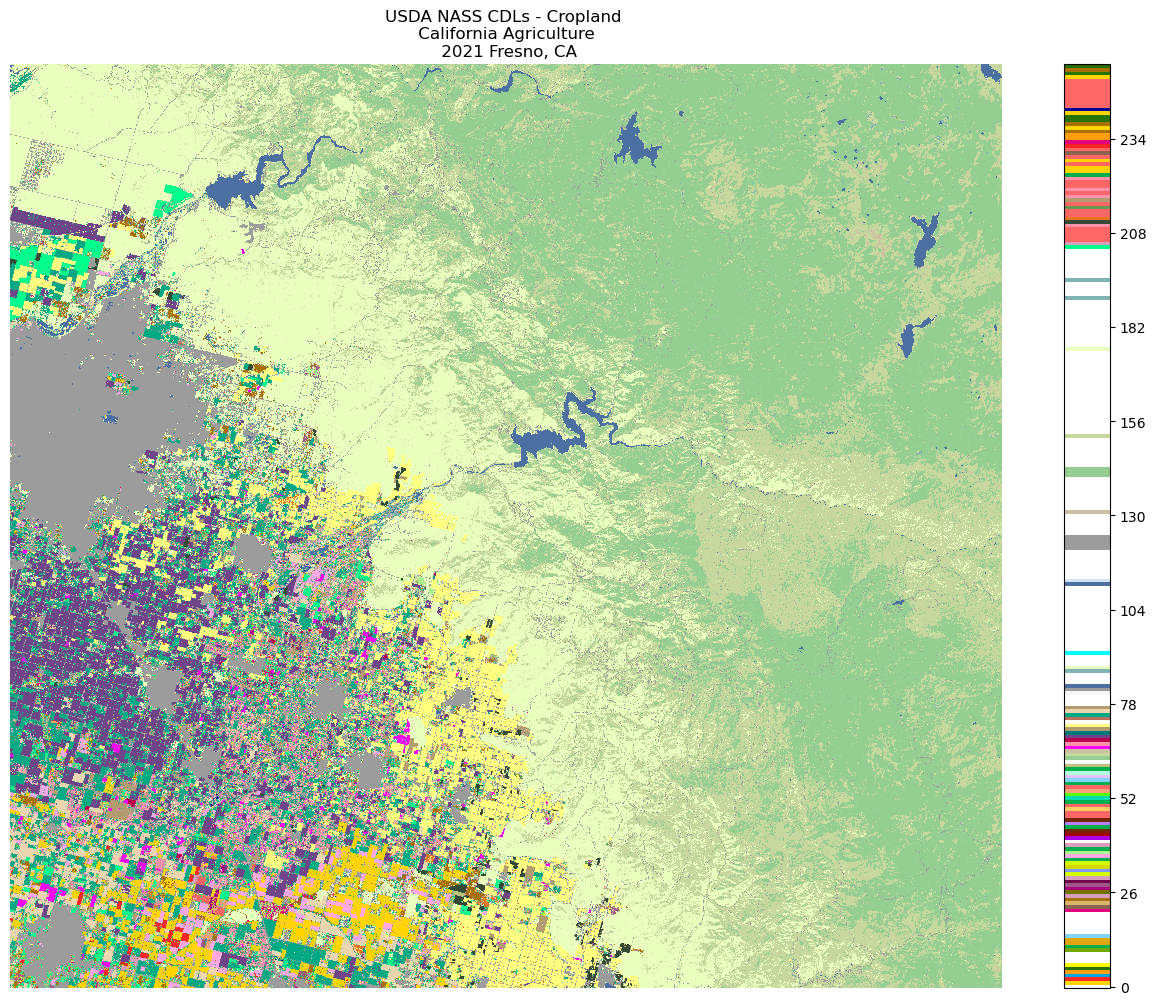

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

p = ds.plot(
    ax=ax,
    cmap=cmap,
    norm=matplotlib.colors.NoNorm(),
)

ax.set_axis_off()
ax.set_title("USDA NASS CDLs - Cropland \n California Agriculture \n 2021 Fresno, CA")

colorbar = fig.axes[1]